# Bicing Usage - Training an Estimator and Deploy the Predictor 

## Uploading Data to S3

Data converted to Json are uploaded to S3, to make them accessible to an estimator in Sagemaker.

### Sagemaker resources

Let's start by specifying:
* The sagemaker role and session for training a model.
* A default S3 bucket where we can save our training, test, and model data.

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import boto3
import sagemaker
from sagemaker import get_execution_role

# session, role, bucket
sagemaker_session = sagemaker.Session()
role = get_execution_role()

bucket = sagemaker_session.default_bucket()

### Upoading training and test JSON files to S3

Specify *unique* train and test prefixes that define the location of that data in S3.
* Upload training data to a location in S3, and save that location to `train_path`
* Upload test data to a location in S3, and save that location to `test_path`

In [2]:
# general prefix
prefix='BicingUsageProject'

# directories where train/test data are saved
data_dir = 'json_bicing_data'
train_key = os.path.join(data_dir, 'train.json')
test_key = os.path.join(data_dir, 'test.json')

# *unique* train/test prefixes
train_prefix   = '{}/{}'.format(prefix, 'train')
test_prefix    = '{}/{}'.format(prefix, 'test')

# uploading data to S3, and saving locations
train_path  = sagemaker_session.upload_data(train_key, bucket=bucket, key_prefix=train_prefix)
test_path   = sagemaker_session.upload_data(test_key,  bucket=bucket, key_prefix=test_prefix)

In [3]:
# check locations
print('Training data is stored in: '+ train_path)
print('Test data is stored in: '+ test_path)

Training data is stored in: s3://sagemaker-us-east-1-753355991757/BicingUsageProject/train/train.json
Test data is stored in: s3://sagemaker-us-east-1-753355991757/BicingUsageProject/test/test.json


The following utility function should convert the JSON strings back into `pandas.Series`.

In [4]:
def json_obj_to_series(ts_jo):
    '''Returns a dictionary of values in DeepAR, JSON format.
       :param ts_jo: A single json object of a time series.
       :return: A dictionary of values with "start" and "target" keys.
       '''
    # get start time and target from the time series, ts
    json_obj = {"start": str(ts.index[0]), "target": list(ts)}
    return series

## Training a DeepAR Estimator

Some estimators have specific, SageMaker constructors, but not all. Instead you can create a base `Estimator` and pass in the specific image (or container) that holds a specific model.

Next, we configure the container image to be used for the region that we are running in.

In [5]:
from sagemaker import image_uris

image_name = image_uris.retrieve('forecasting-deepar', # specify image
                           boto3.Session().region_name) # get the region

### Instantiate an Estimator 

You can now define the estimator that will launch the training job. A generic Estimator will be defined by the usual constructor arguments and an `image_name`. 
> You can take a look at the [estimator source code](https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/estimator.py#L595) to view specifics.


In [8]:
from sagemaker.estimator import Estimator

# dir to save model artifacts
s3_output_path = "s3://{}/{}/output".format(bucket, prefix)

# instantiate a DeepAR estimator
estimator = Estimator(sagemaker_session=sagemaker_session,
                      image_uri=image_name,
                      role=role,
                      instance_count=1,
                      instance_type='ml.c4.xlarge',
                      output_path=s3_output_path
                      )

## Setting Hyperparameters

Next, we need to define some DeepAR hyperparameters that define the model size and training behavior. Values for the epochs, frequency, prediction length, and context length are required.

* **epochs**: The maximum number of times to pass over the data when training.
* **time_freq**: The granularity of the time series in the dataset ('D' for daily).
* **prediction_length**: A string; the number of time steps (based off the unit of frequency) that the model is trained to predict. 
* **context_length**: The number of time points that the model gets to see *before* making a prediction. 

### Context Length

Typically, it is recommended that you start with a `context_length`=`prediction_length`. This is because a DeepAR model also receives "lagged" inputs from the target time series, which allow the model to capture long-term dependencies. For example, a daily time series can have yearly seasonality and DeepAR automatically includes a lag of one year. So, the context length can be shorter than a year, and the model will still be able to capture this seasonality. 

The lag values that the model picks depend on the frequency of the time series. For example, lag values for daily frequency are the previous week, 2 weeks, 3 weeks, 4 weeks, and year. You can read more about this in the [DeepAR "how it works" documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_how-it-works.html).

### Optional Hyperparameters

You can also configure optional hyperparameters to further tune your model. These include parameters like the number of layers in our RNN model, the number of cells per layer, the likelihood function, and the training options, such as batch size and learning rate. 

For an exhaustive list of all the different DeepAR hyperparameters you can refer to the DeepAR [hyperparameter documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html).

In [9]:
# prediction length from Data Analysis
prediction_length = 7*24 # 7 days, a week, 168 hours

freq='H'
context_length=7*24 # same as prediction_length

hyperparameters = {
    "epochs": "50",
    "time_freq": freq,
    "prediction_length": str(prediction_length),
    "context_length": str(context_length),
    "num_cells": "50",
    "num_layers": "2",
    "mini_batch_size": "128",
    "learning_rate": "0.001",
    "early_stopping_patience": "10"
}

In [10]:
# set the hyperparams
estimator.set_hyperparameters(**hyperparameters)

## Training Job

Launching of the training job!

The `test` data is also provided to calculate accuracy metrics for the trained model on the data set. The computed error metrics are included as part of the log output.

This cell takes few minutes to complete.

In [11]:
%%time
# train and test channels
data_channels = {
    "train": train_path,
    "test": test_path
}

# fit the estimator
estimator.fit(inputs=data_channels)

2021-05-16 10:35:17 Starting - Starting the training job...
2021-05-16 10:35:43 Starting - Launching requested ML instancesProfilerReport-1621161317: InProgress
......
2021-05-16 10:36:43 Starting - Preparing the instances for training......
2021-05-16 10:37:44 Downloading - Downloading input data
2021-05-16 10:37:44 Training - Downloading the training image......
2021-05-16 10:38:44 Training - Training image download completed. Training in progress.Arguments: train
[05/16/2021 10:38:39 INFO 139930305979776] Reading default configuration from /opt/amazon/lib/python3.6/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood': 'student-t', 'mini_batch_size': '128', 'num_cells': '40', 'num_dynamic_feat': 'auto', 'num_eval_samples': '100', 'num_layer

[05/16/2021 10:39:13 INFO 139930305979776] Epoch[2] Batch[5] avg_epoch_loss=2.142001
[05/16/2021 10:39:13 INFO 139930305979776] #quality_metric: host=algo-1, epoch=2, batch=5 train loss <loss>=2.142001191775004
[05/16/2021 10:39:13 INFO 139930305979776] Epoch[2] Batch [5]#011Speed: 124.80 samples/sec#011loss=2.142001
[05/16/2021 10:39:18 INFO 139930305979776] processed a total of 1216 examples
#metrics {"StartTime": 1621161547.2118933, "EndTime": 1621161558.120405, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 10908.416748046875, "count": 1, "min": 10908.416748046875, "max": 10908.416748046875}}}

[05/16/2021 10:39:18 INFO 139930305979776] #throughput_metric: host=algo-1, train throughput=111.4718792958083 records/second
[05/16/2021 10:39:18 INFO 139930305979776] #progress_metric: host=algo-1, completed 6.0 % of epochs
[05/16/2021 10:39:18 INFO 139930305979776] #quality_metric: host=algo-1, epoch=2, train loss <

[05/16/2021 10:40:10 INFO 139930305979776] Epoch[7] Batch[5] avg_epoch_loss=2.125614
[05/16/2021 10:40:10 INFO 139930305979776] #quality_metric: host=algo-1, epoch=7, batch=5 train loss <loss>=2.125613888104757
[05/16/2021 10:40:10 INFO 139930305979776] Epoch[7] Batch [5]#011Speed: 107.27 samples/sec#011loss=2.125614
[05/16/2021 10:40:15 INFO 139930305979776] Epoch[7] Batch[10] avg_epoch_loss=2.108716
[05/16/2021 10:40:15 INFO 139930305979776] #quality_metric: host=algo-1, epoch=7, batch=10 train loss <loss>=2.0884382724761963
[05/16/2021 10:40:15 INFO 139930305979776] Epoch[7] Batch [10]#011Speed: 124.82 samples/sec#011loss=2.088438
[05/16/2021 10:40:15 INFO 139930305979776] processed a total of 1294 examples
#metrics {"StartTime": 1621161602.760112, "EndTime": 1621161615.3666039, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 12606.420755386353, "count": 1, "min": 12606.420755386353, "max": 12606.420755386353}}

[05/16/2021 10:41:20 INFO 139930305979776] Epoch[13] Batch[5] avg_epoch_loss=2.067441
[05/16/2021 10:41:20 INFO 139930305979776] #quality_metric: host=algo-1, epoch=13, batch=5 train loss <loss>=2.067441244920095
[05/16/2021 10:41:20 INFO 139930305979776] Epoch[13] Batch [5]#011Speed: 124.17 samples/sec#011loss=2.067441
[05/16/2021 10:41:24 INFO 139930305979776] processed a total of 1271 examples
#metrics {"StartTime": 1621161673.659982, "EndTime": 1621161684.4103687, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 10750.293731689453, "count": 1, "min": 10750.293731689453, "max": 10750.293731689453}}}

[05/16/2021 10:41:24 INFO 139930305979776] #throughput_metric: host=algo-1, train throughput=118.22729296120342 records/second
[05/16/2021 10:41:24 INFO 139930305979776] #progress_metric: host=algo-1, completed 28.0 % of epochs
[05/16/2021 10:41:24 INFO 139930305979776] #quality_metric: host=algo-1, epoch=13, train 

[05/16/2021 10:42:30 INFO 139930305979776] Epoch[19] Batch[5] avg_epoch_loss=1.958713
[05/16/2021 10:42:30 INFO 139930305979776] #quality_metric: host=algo-1, epoch=19, batch=5 train loss <loss>=1.958712915579478
[05/16/2021 10:42:30 INFO 139930305979776] Epoch[19] Batch [5]#011Speed: 124.92 samples/sec#011loss=1.958713
[05/16/2021 10:42:34 INFO 139930305979776] processed a total of 1269 examples
#metrics {"StartTime": 1621161743.473154, "EndTime": 1621161754.2042139, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 10730.56411743164, "count": 1, "min": 10730.56411743164, "max": 10730.56411743164}}}

[05/16/2021 10:42:34 INFO 139930305979776] #throughput_metric: host=algo-1, train throughput=118.25891400787664 records/second
[05/16/2021 10:42:34 INFO 139930305979776] #progress_metric: host=algo-1, completed 40.0 % of epochs
[05/16/2021 10:42:34 INFO 139930305979776] #quality_metric: host=algo-1, epoch=19, train los

[05/16/2021 10:43:28 INFO 139930305979776] Epoch[24] Batch[5] avg_epoch_loss=1.920685
[05/16/2021 10:43:28 INFO 139930305979776] #quality_metric: host=algo-1, epoch=24, batch=5 train loss <loss>=1.920684536298116
[05/16/2021 10:43:28 INFO 139930305979776] Epoch[24] Batch [5]#011Speed: 125.94 samples/sec#011loss=1.920685
[05/16/2021 10:43:32 INFO 139930305979776] processed a total of 1269 examples
#metrics {"StartTime": 1621161801.4295022, "EndTime": 1621161812.1518502, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 10721.799850463867, "count": 1, "min": 10721.799850463867, "max": 10721.799850463867}}}

[05/16/2021 10:43:32 INFO 139930305979776] #throughput_metric: host=algo-1, train throughput=118.35558064331423 records/second
[05/16/2021 10:43:32 INFO 139930305979776] #progress_metric: host=algo-1, completed 50.0 % of epochs
[05/16/2021 10:43:32 INFO 139930305979776] #quality_metric: host=algo-1, epoch=24, train

[05/16/2021 10:44:31 INFO 139930305979776] Epoch[29] Batch[10] avg_epoch_loss=1.912664
[05/16/2021 10:44:31 INFO 139930305979776] #quality_metric: host=algo-1, epoch=29, batch=10 train loss <loss>=1.896975326538086
[05/16/2021 10:44:31 INFO 139930305979776] Epoch[29] Batch [10]#011Speed: 123.85 samples/sec#011loss=1.896975
[05/16/2021 10:44:31 INFO 139930305979776] processed a total of 1396 examples
#metrics {"StartTime": 1621161859.4990568, "EndTime": 1621161871.2551994, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 11755.507469177246, "count": 1, "min": 11755.507469177246, "max": 11755.507469177246}}}

[05/16/2021 10:44:31 INFO 139930305979776] #throughput_metric: host=algo-1, train throughput=118.75149275246069 records/second
[05/16/2021 10:44:31 INFO 139930305979776] #progress_metric: host=algo-1, completed 60.0 % of epochs
[05/16/2021 10:44:31 INFO 139930305979776] #quality_metric: host=algo-1, epoch=29, tr

[05/16/2021 10:45:26 INFO 139930305979776] Epoch[34] Batch[5] avg_epoch_loss=1.886048
[05/16/2021 10:45:26 INFO 139930305979776] #quality_metric: host=algo-1, epoch=34, batch=5 train loss <loss>=1.8860478798548381
[05/16/2021 10:45:26 INFO 139930305979776] Epoch[34] Batch [5]#011Speed: 124.27 samples/sec#011loss=1.886048
[05/16/2021 10:45:30 INFO 139930305979776] processed a total of 1248 examples
#metrics {"StartTime": 1621161919.5695279, "EndTime": 1621161930.2923825, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 10722.283601760864, "count": 1, "min": 10722.283601760864, "max": 10722.283601760864}}}

[05/16/2021 10:45:30 INFO 139930305979776] #throughput_metric: host=algo-1, train throughput=116.39143126408173 records/second
[05/16/2021 10:45:30 INFO 139930305979776] #progress_metric: host=algo-1, completed 70.0 % of epochs
[05/16/2021 10:45:30 INFO 139930305979776] #quality_metric: host=algo-1, epoch=34, trai

[05/16/2021 10:46:23 INFO 139930305979776] Epoch[39] Batch[5] avg_epoch_loss=2.379897
[05/16/2021 10:46:23 INFO 139930305979776] #quality_metric: host=algo-1, epoch=39, batch=5 train loss <loss>=2.3798967202504477
[05/16/2021 10:46:23 INFO 139930305979776] Epoch[39] Batch [5]#011Speed: 125.04 samples/sec#011loss=2.379897
[05/16/2021 10:46:27 INFO 139930305979776] processed a total of 1257 examples
#metrics {"StartTime": 1621161976.5429487, "EndTime": 1621161987.2427266, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 10699.700832366943, "count": 1, "min": 10699.700832366943, "max": 10699.700832366943}}}

[05/16/2021 10:46:27 INFO 139930305979776] #throughput_metric: host=algo-1, train throughput=117.47834432600092 records/second
[05/16/2021 10:46:27 INFO 139930305979776] #progress_metric: host=algo-1, completed 80.0 % of epochs
[05/16/2021 10:46:27 INFO 139930305979776] #quality_metric: host=algo-1, epoch=39, trai

[05/16/2021 10:47:25 INFO 139930305979776] Epoch[45] Batch[0] avg_epoch_loss=1.904311
[05/16/2021 10:47:25 INFO 139930305979776] #quality_metric: host=algo-1, epoch=45, batch=0 train loss <loss>=1.9043112993240356
[05/16/2021 10:47:31 INFO 139930305979776] Epoch[45] Batch[5] avg_epoch_loss=1.953354
[05/16/2021 10:47:31 INFO 139930305979776] #quality_metric: host=algo-1, epoch=45, batch=5 train loss <loss>=1.9533544778823853
[05/16/2021 10:47:31 INFO 139930305979776] Epoch[45] Batch [5]#011Speed: 122.37 samples/sec#011loss=1.953354
[05/16/2021 10:47:35 INFO 139930305979776] processed a total of 1201 examples
#metrics {"StartTime": 1621162044.3714266, "EndTime": 1621162055.1980648, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 10826.045989990234, "count": 1, "min": 10826.045989990234, "max": 10826.045989990234}}}

[05/16/2021 10:47:35 INFO 139930305979776] #throughput_metric: host=algo-1, train throughput=110.9345

#metrics {"StartTime": 1621162093.5453937, "EndTime": 1621162118.5694304, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"model.score.time": {"sum": 25024.129629135132, "count": 1, "min": 25024.129629135132, "max": 25024.129629135132}}}

[05/16/2021 10:48:38 INFO 139930305979776] #test_score (algo-1, RMSE): 4.321355509439497
[05/16/2021 10:48:38 INFO 139930305979776] #test_score (algo-1, mean_absolute_QuantileLoss): 30803.83847904325
[05/16/2021 10:48:38 INFO 139930305979776] #test_score (algo-1, mean_wQuantileLoss): 0.8456088305436272
[05/16/2021 10:48:38 INFO 139930305979776] #test_score (algo-1, wQuantileLoss[0.1]): 0.6469515828087151
[05/16/2021 10:48:38 INFO 139930305979776] #test_score (algo-1, wQuantileLoss[0.2]): 0.8361747105666136
[05/16/2021 10:48:38 INFO 139930305979776] #test_score (algo-1, wQuantileLoss[0.3]): 0.931793345059086
[05/16/2021 10:48:38 INFO 139930305979776] #test_score (algo-1, wQuantileLoss[0.4]): 0.981691282

## Deploy and Create a Predictor

Now that the trained model is ready, it can be used to perform predictions by deploying it to a predictor endpoint.

Remember to **delete the endpoint** at the end of this notebook. A cell at the very bottom of this notebook will be provided, but it is always good to keep, front-of-mind.

In [12]:
%%time
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import JSONSerializer


# create a predictor
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    serializer=JSONSerializer(),
    deserializer= JSONDeserializer()
)

-----------------!CPU times: user 273 ms, sys: 27.7 ms, total: 300 ms
Wall time: 8min 32s


# Generating Predictions

According to the [inference format](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar-in-formats.html) for DeepAR, the `predictor` expects to see input data in a JSON format, with the following keys:
* **instances**: A list of JSON-formatted time series that should be forecast by the model.
* **configuration** (optional): A dictionary of configuration information for the type of response desired by the request.

Within configuration the following keys can be configured:
* **num_samples**: An integer specifying the number of samples that the model generates when making a probabilistic prediction.
* **output_types**: A list specifying the type of response. We'll ask for **quantiles**, which look at the list of num_samples generated by the model, and generate [quantile estimates](https://en.wikipedia.org/wiki/Quantile) for each time point based on these values.
* **quantiles**: A list that specified which quantiles estimates are generated and returned in the response.


Below is an example of what a JSON query to a DeepAR model endpoint might look like.

```
{
 "instances": [
  { "start": "2009-11-01 00:00:00", "target": [4.0, 10.0, 50.0, 100.0, 113.0] },
  { "start": "1999-01-30", "target": [2.0, 1.0] }
 ],
 "configuration": {
  "num_samples": 50,
  "output_types": ["quantiles"],
  "quantiles": ["0.5", "0.9"]
 }
}
```


## JSON Prediction Request

The code below accepts a json file containing the instances information as input and some configuration parameters. It then combine the data in the json file with the configuration into a JSON instance and converts the input into the appropriately formatted JSON_input.

In [13]:
import json

def json_predictor_input_from_file(input_file, num_samples=50, quantiles=['0.1', '0.5', '0.9']):
    '''Accepts a list of input time series and produces a formatted input.
       :input_file: An json file properly formatted as a list of line like '{ "start": "2009-11-01 00:00:00", "target": [4.0, 10.0, 50.0, 100.0, 113.0] }'.
       :num_samples: Number of samples to calculate metrics with.
       :quantiles: A list of quantiles to return in the predicted output.
       :return: The JSON-formatted input.
       '''
    # request data is made of JSON objects (instances)
    # and an output configuration that details the type of data/quantiles we want
    
    instances = []
    with open(input_file) as json_file:

        for line in json_file:
            # get JSON objects for input time series
            instances.append(json.loads(line))
            

    # specify the output quantiles and samples
    configuration = {"num_samples": num_samples, 
                     "output_types": ["quantiles"], 
                     "quantiles": quantiles}

    request_data = {"instances": instances, 
                    "configuration": configuration}

    json_request = request_data
    
    return json_request
        

### Get a Prediction

We can then use this function to get a prediction for a formatted time series!

In the next cell, I'm getting an input time series and known target, and passing the formatted input into the predictor endpoint to get a resultant prediction.

In [14]:
# get formatted input time series
json_input_ts = json_predictor_input_from_file(train_key)

# get the prediction from the predictor
json_prediction = predictor.predict(json_input_ts)

## Decoding Predictions

The predictor returns JSON-formatted prediction, and so we need to extract the predictions and quantile data that we want for visualizing the result. The function below, reads in a JSON-formatted prediction and produces a list of predictions in each quantile.

In [15]:
# helper function to decode JSON prediction
def decode_prediction(prediction):
    '''Accepts a JSON prediction and returns a list of prediction data.
    '''
    prediction_list = []
    for k in range(len(prediction['predictions'])):
        prediction_list.append(pd.DataFrame(data=prediction['predictions'][k]['quantiles']))
    return prediction_list


In [16]:
# get quantiles/predictions
prediction_list = decode_prediction(json_prediction)

# should get a list of (7*24)=167 predictions 
# with corresponding quantile values
print(prediction_list[0])

          0.1       0.5       0.9
0   -0.277178  0.240821  0.728663
1   -0.474382 -0.014035  0.310592
2   -0.169241  0.138045  0.488955
3   -0.630862  0.099647  0.829514
4   -1.545973 -0.312172  0.572953
..        ...       ...       ...
163 -0.110760  0.357143  2.070365
164 -1.043862  0.294365  1.315359
165 -0.116722  0.274141  1.210019
166 -0.248978  0.267352  1.016355
167  0.042424  0.273935  0.760641

[168 rows x 3 columns]


## Display the Results!

The quantile data will give us all we need to see the results of our prediction.
* Quantiles 0.1 and 0.9 represent higher and lower bounds for the predicted values.
* Quantile 0.5 represents the median of all sample predictions.

In [42]:
# display the prediction median against the actual data
def display_quantiles(prediction_list, start_dates, target_ts=None):
    # show predictions for all input ts
    for k in range(len(prediction_list)):
        plt.figure(figsize=(12,6))
        # generate date list
        start_date = start_dates[k]
        timeline = pd.date_range(start_date, periods = len(prediction_list[k]) ,freq='H')
        # get the target month of data
        if target_ts is not None:
            target = target_ts[k][-prediction_length:]
            plt.plot(timeline, target, label='target') #range(len(target))
        # get the quantile values at 10 and 90%
        p10 = prediction_list[k]['0.1']
        p90 = prediction_list[k]['0.9']
        p50 = prediction_list[k]['0.5']
        # fill the 80% confidence interval
        plt.fill_between(timeline, p10, p90, color='y', alpha=0.5, label='80% confidence interval') #p10.index
        # plot the median prediction line
        plt.plot(timeline, p50, label='prediction median')
        plt.legend()
        plt.show()

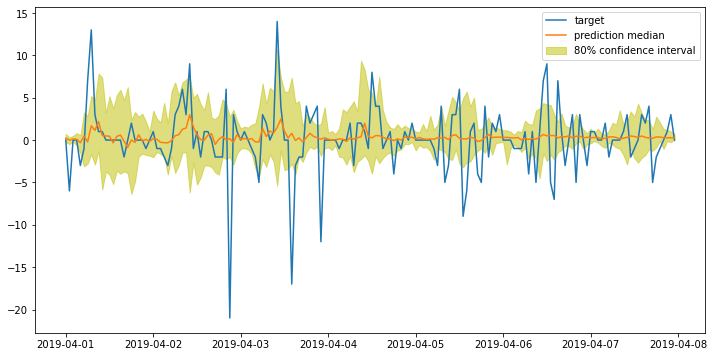

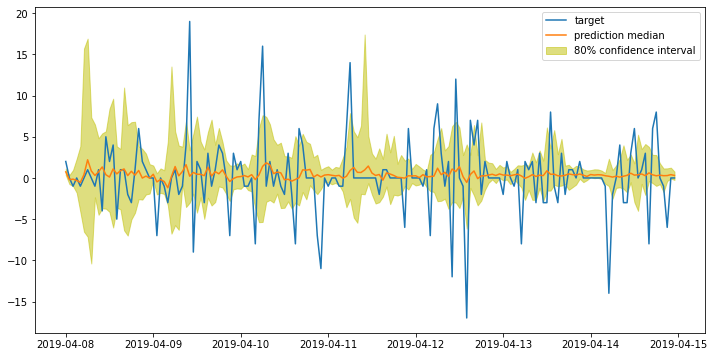

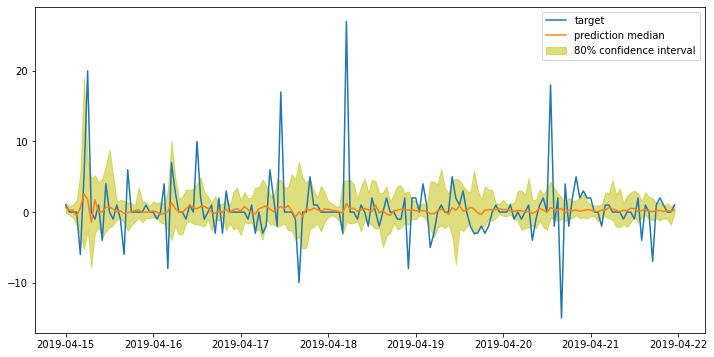

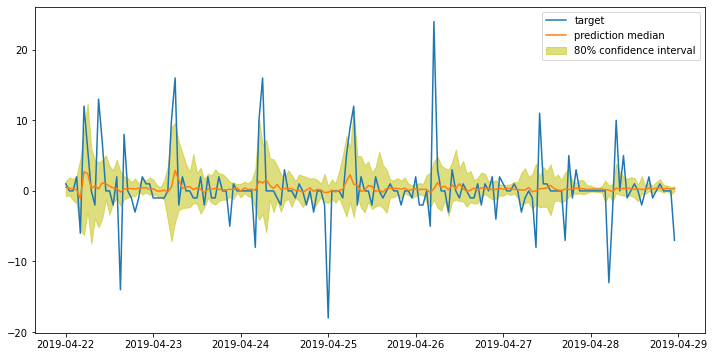

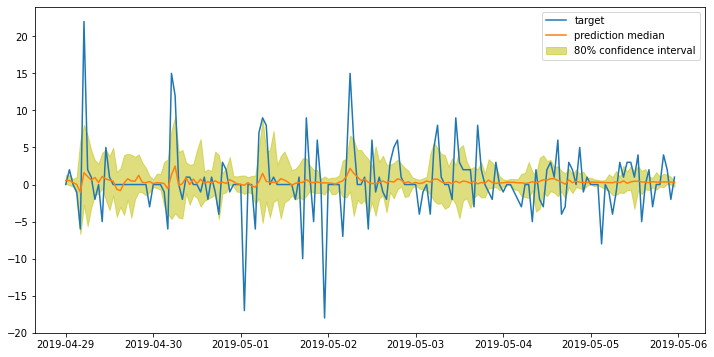

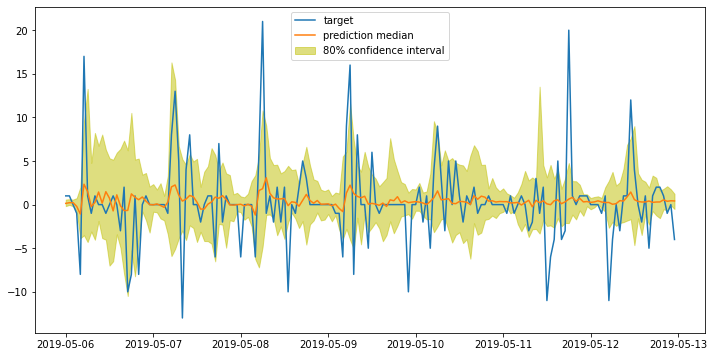

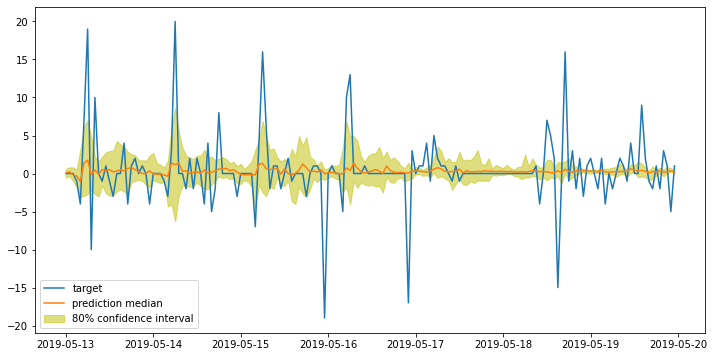

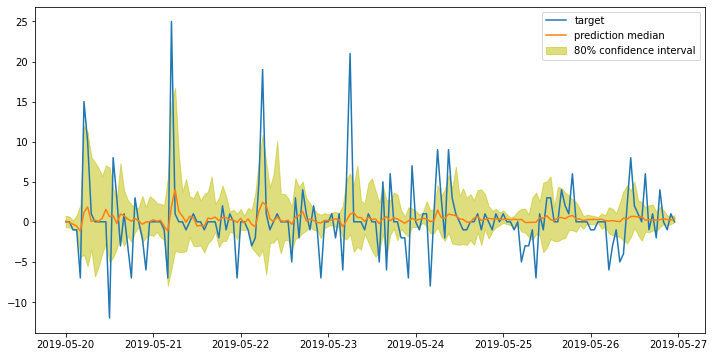

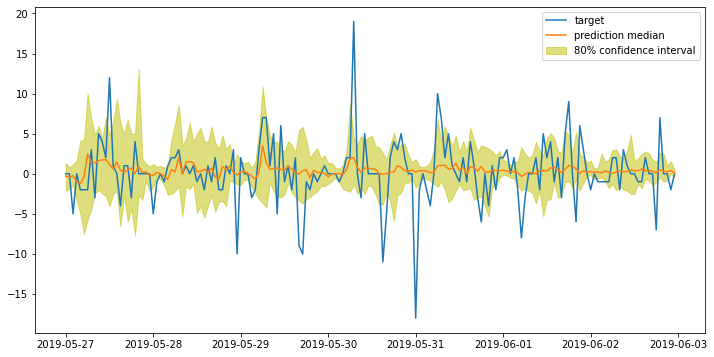

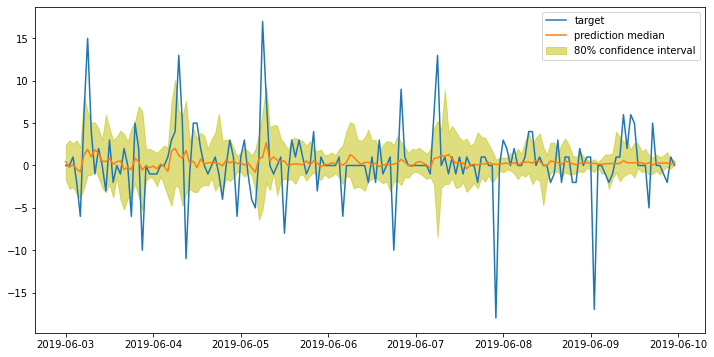

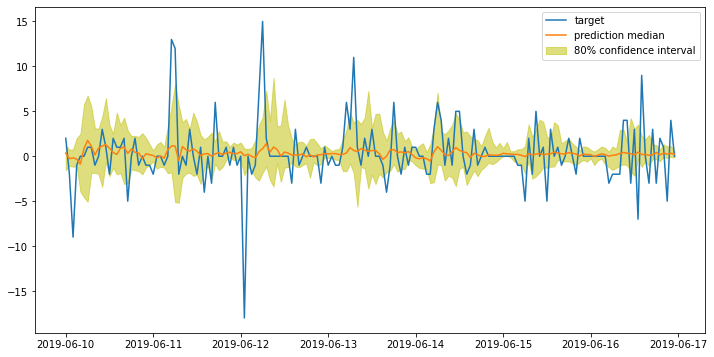

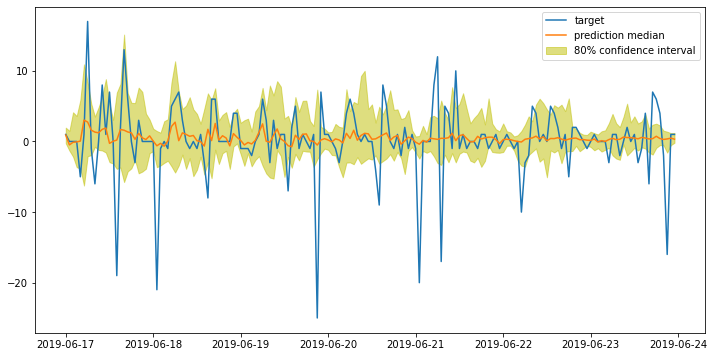

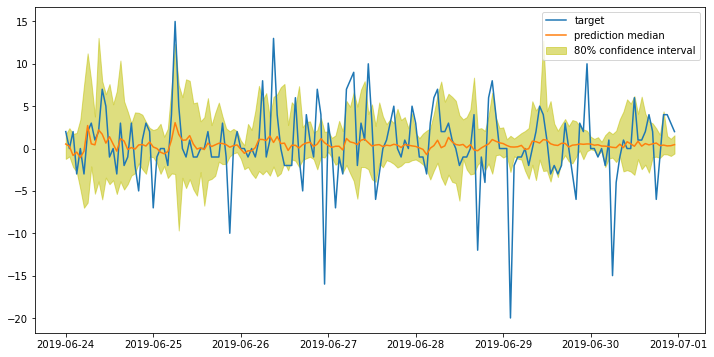

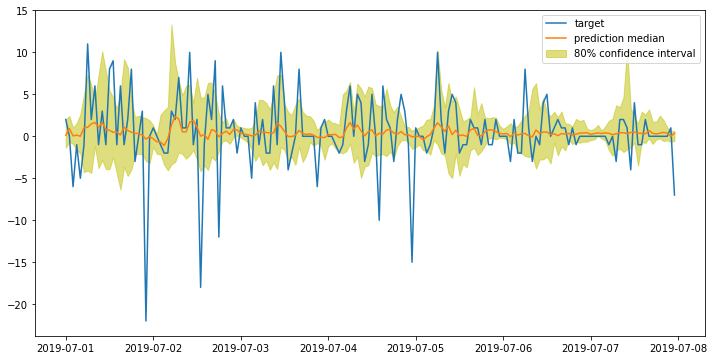

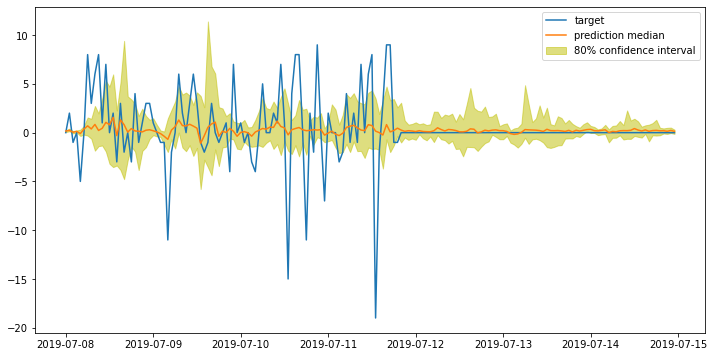

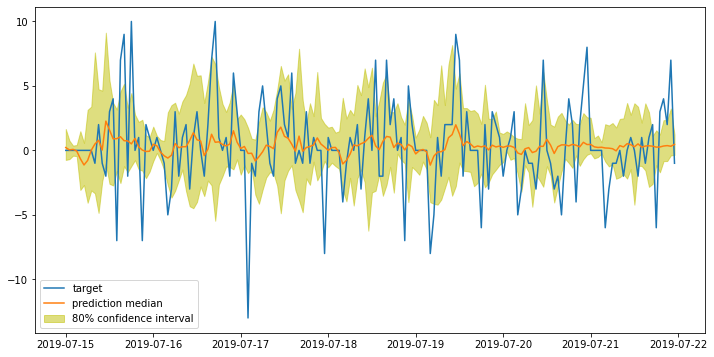

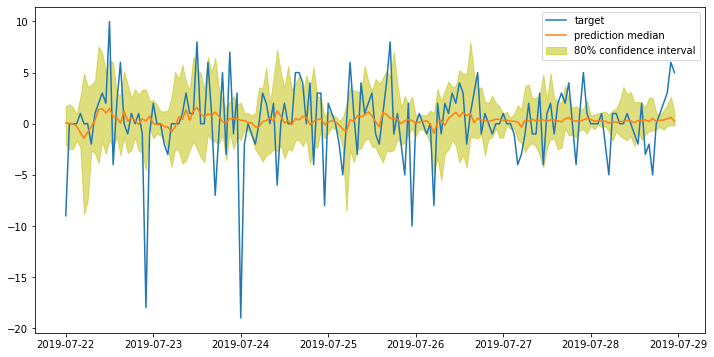

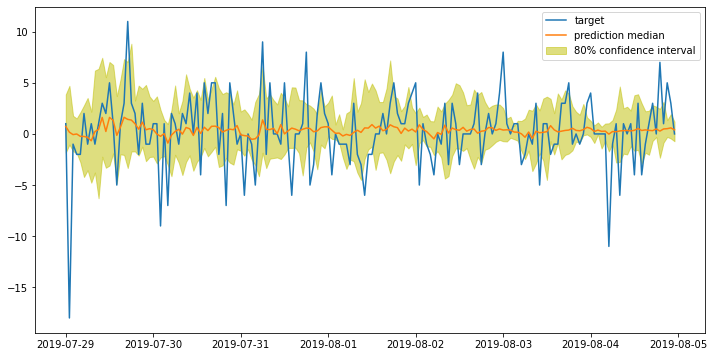

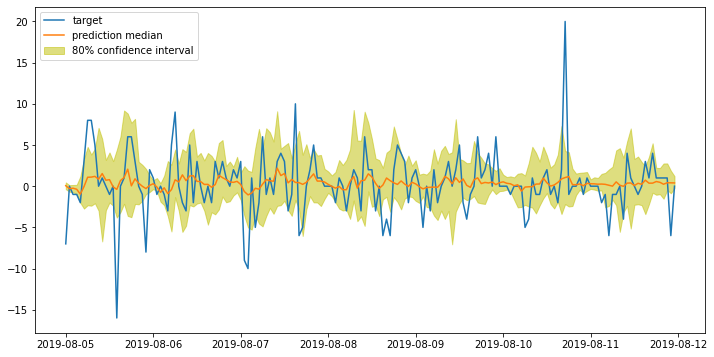

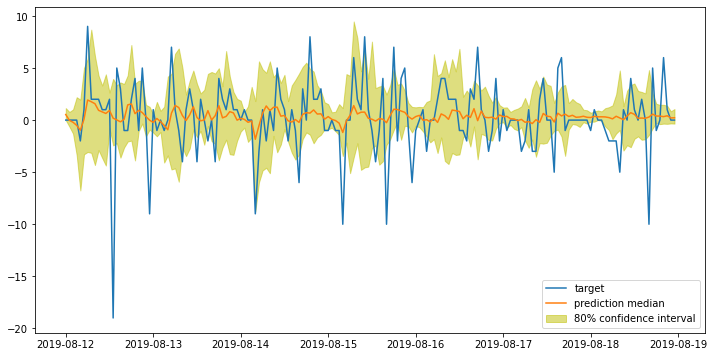

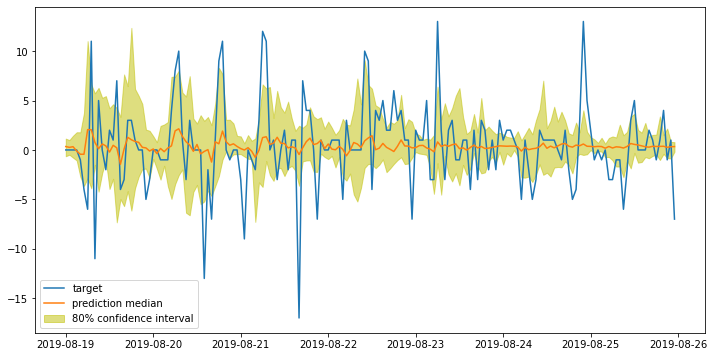

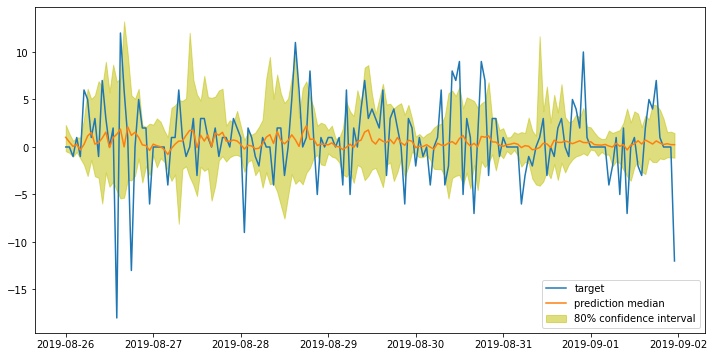

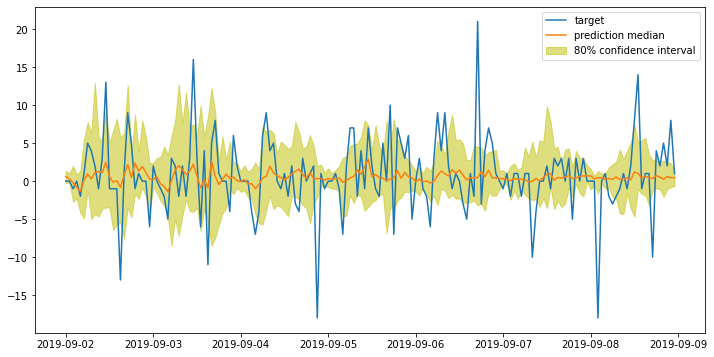

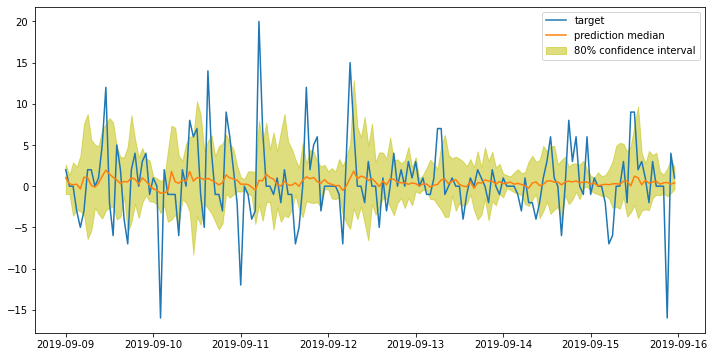

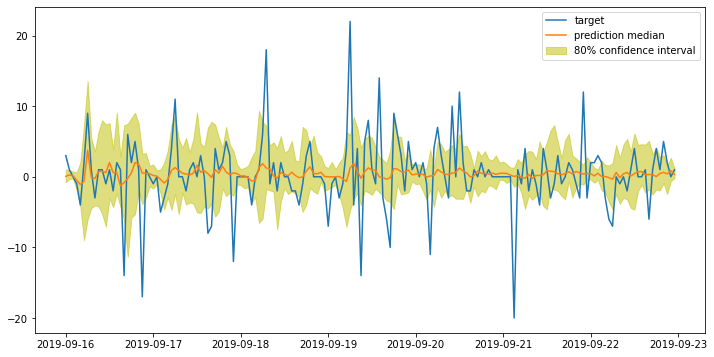

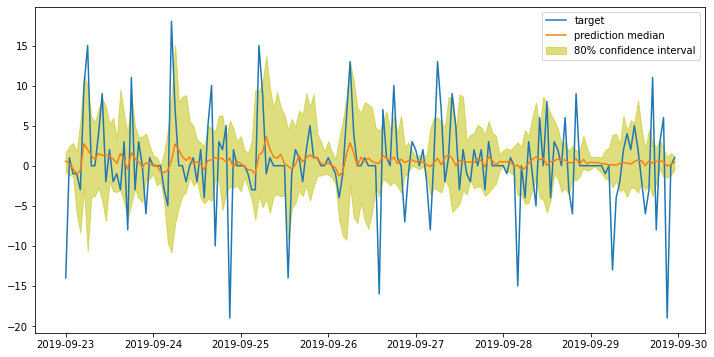

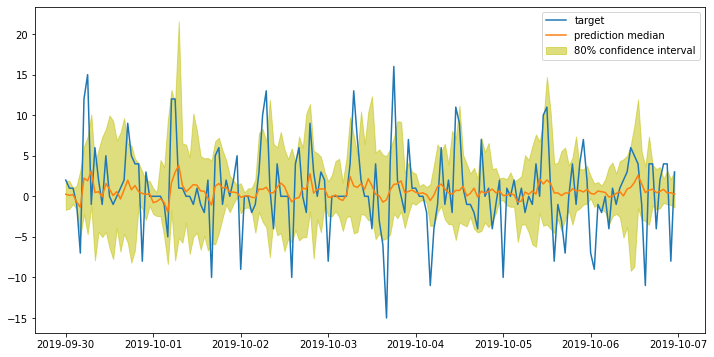

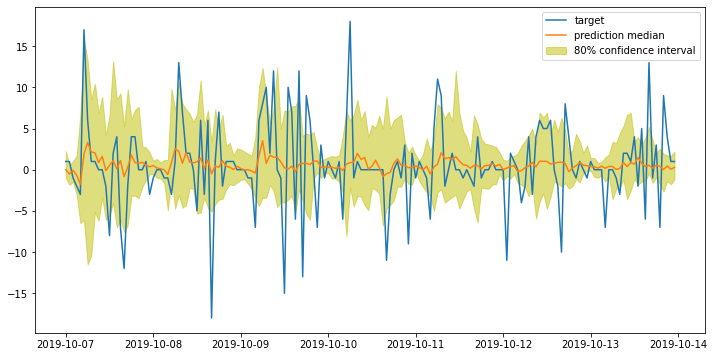

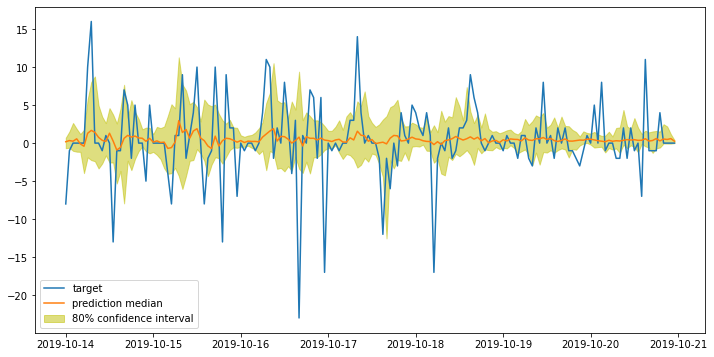

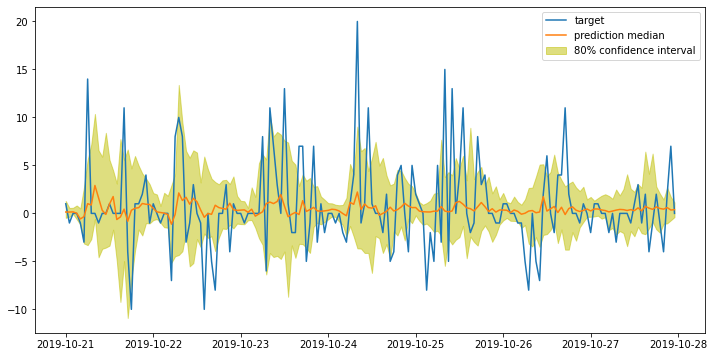

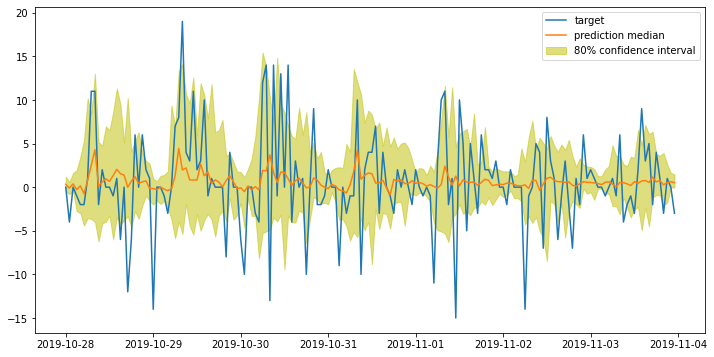

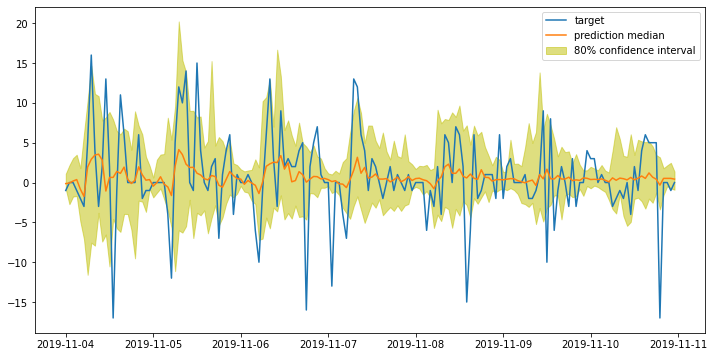

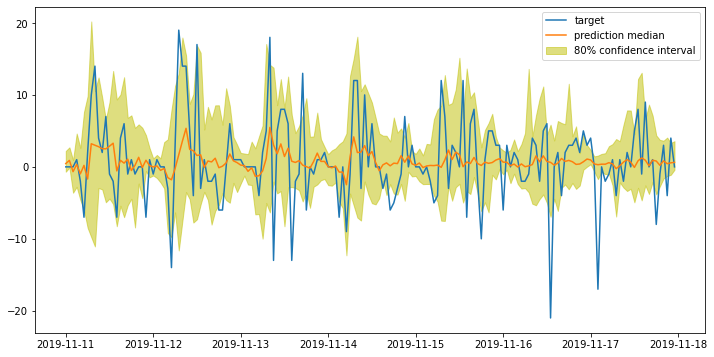

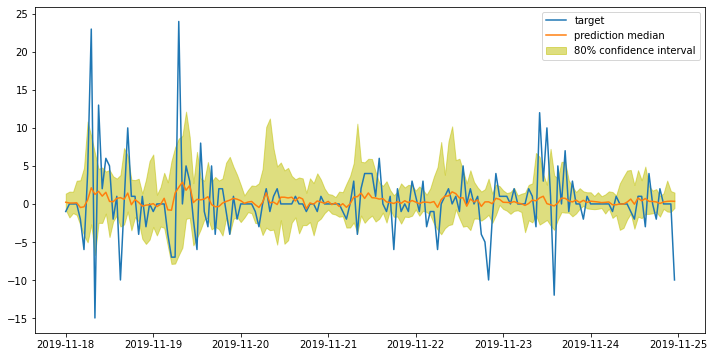

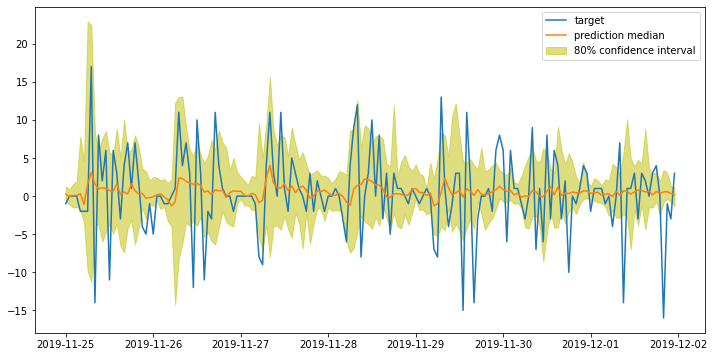

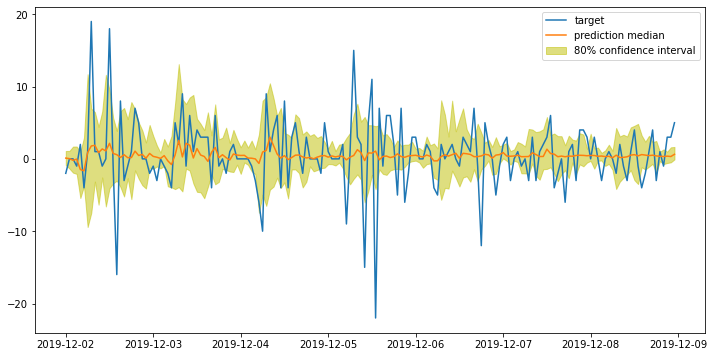

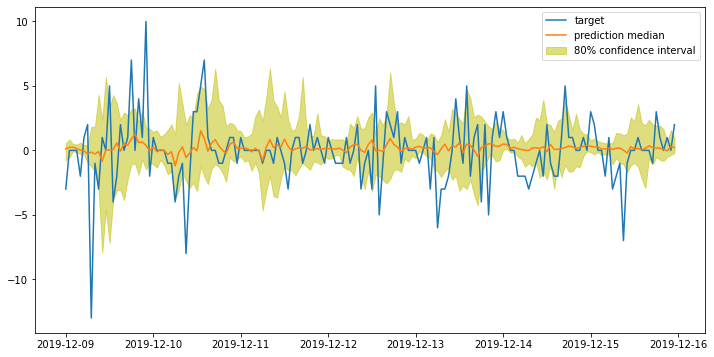

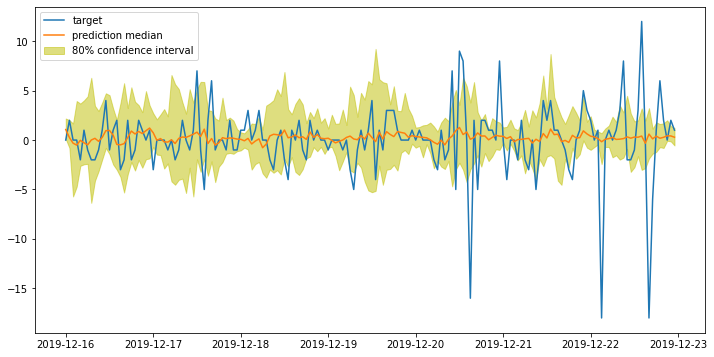

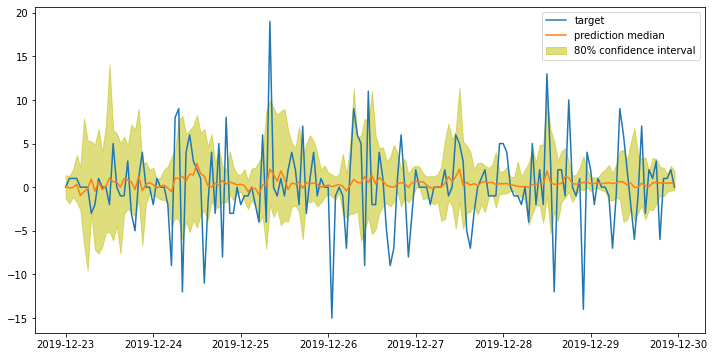

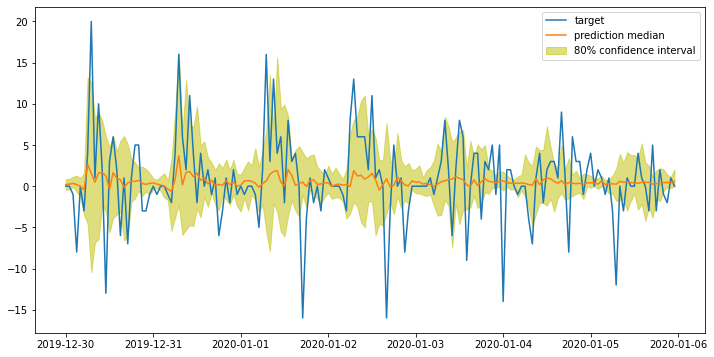

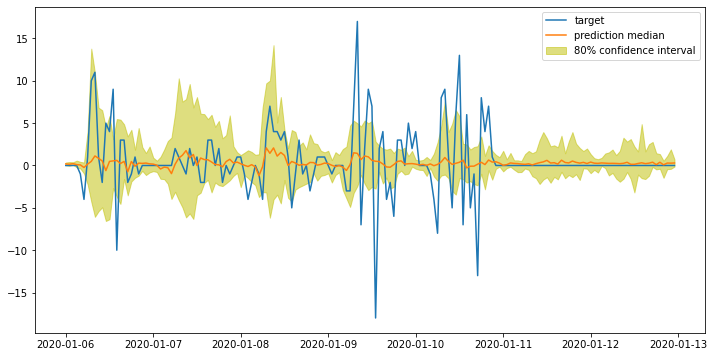

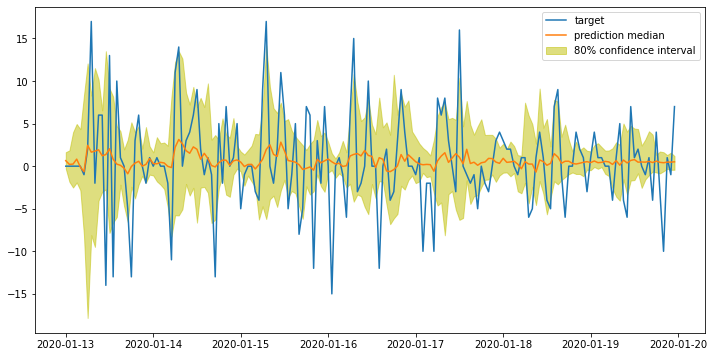

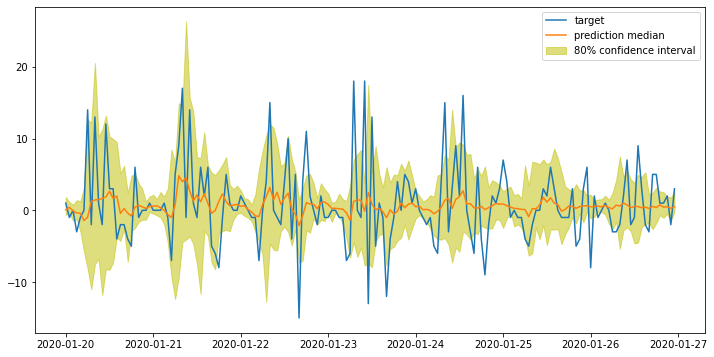

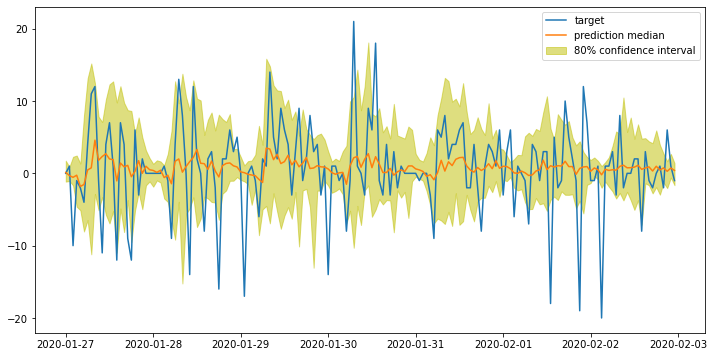

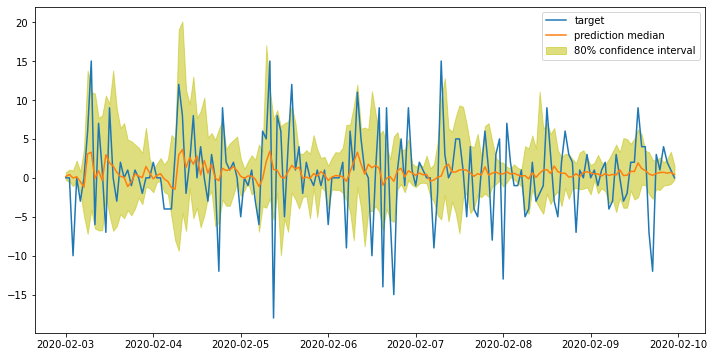

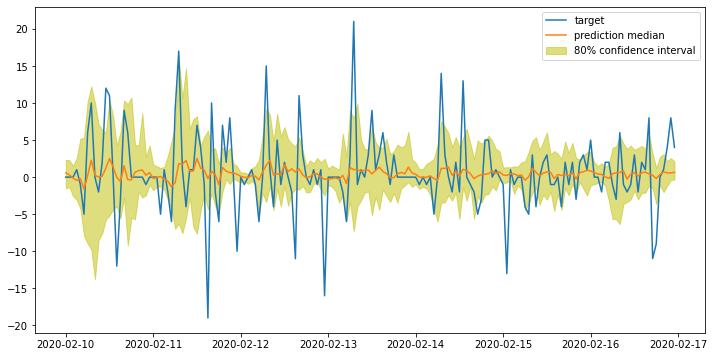

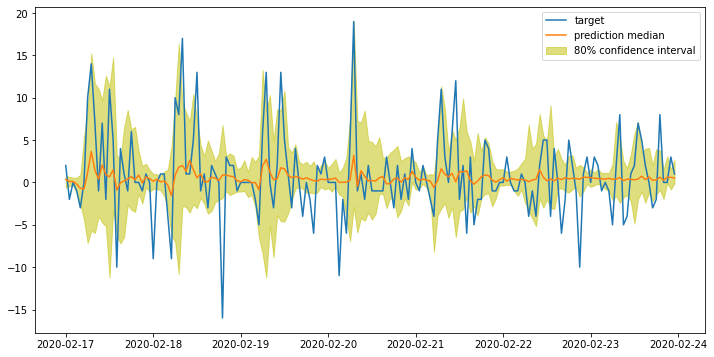

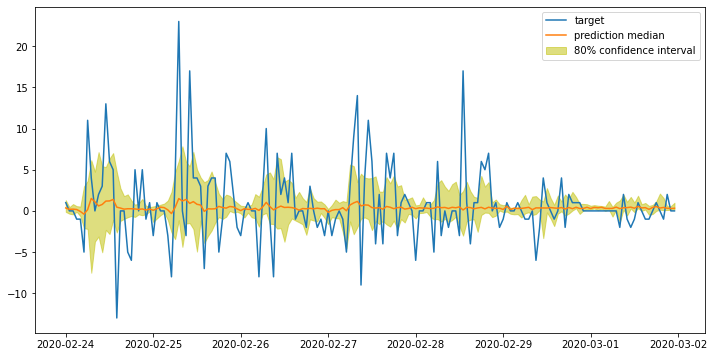

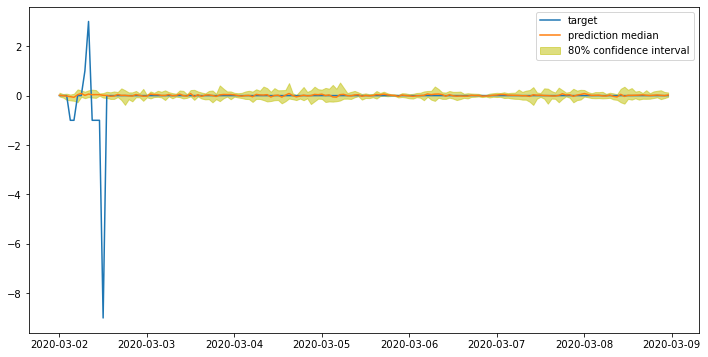

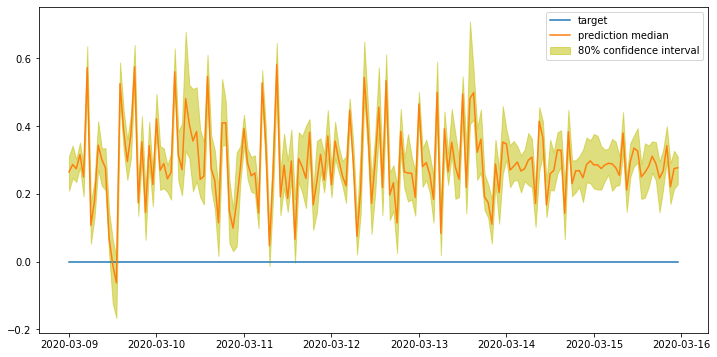

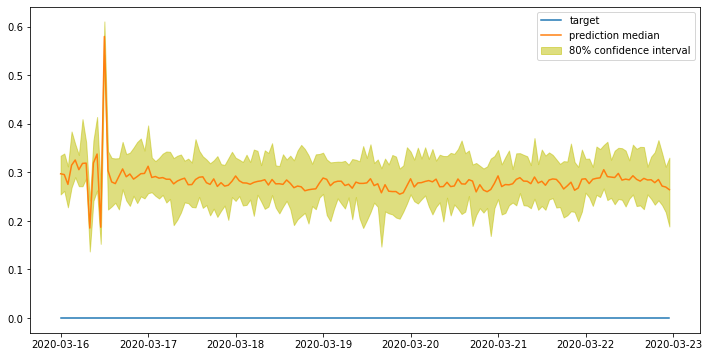

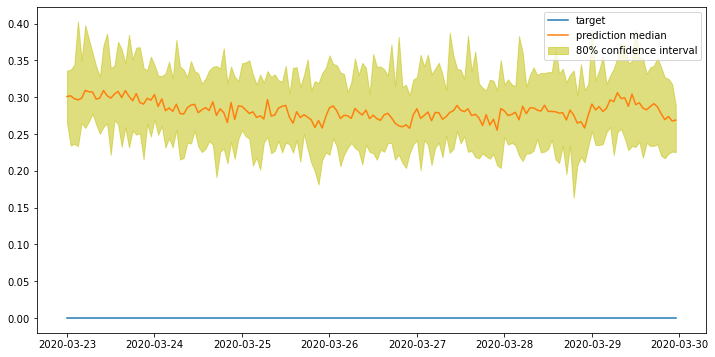

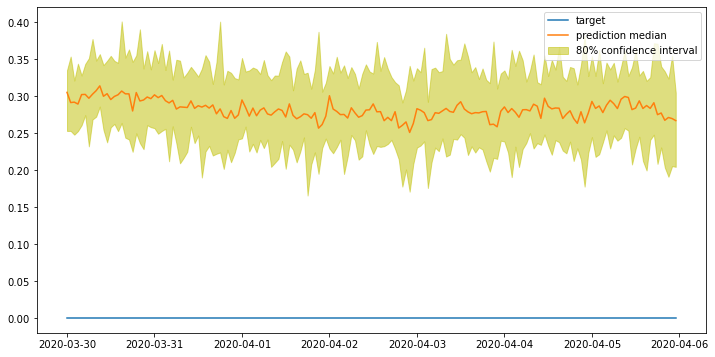

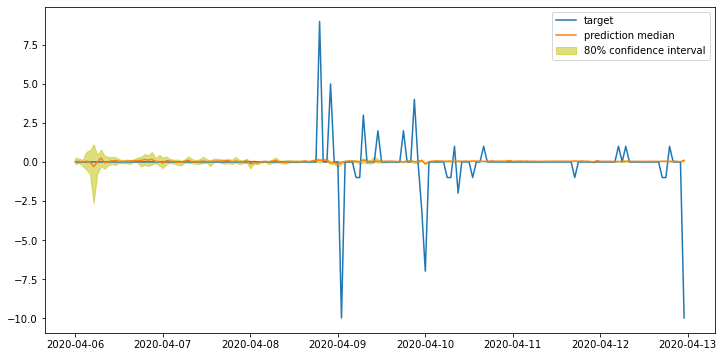

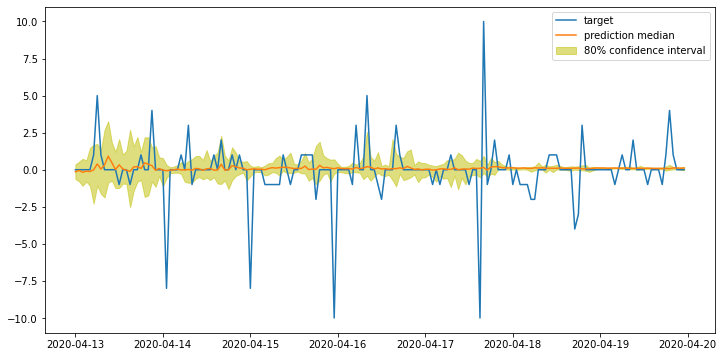

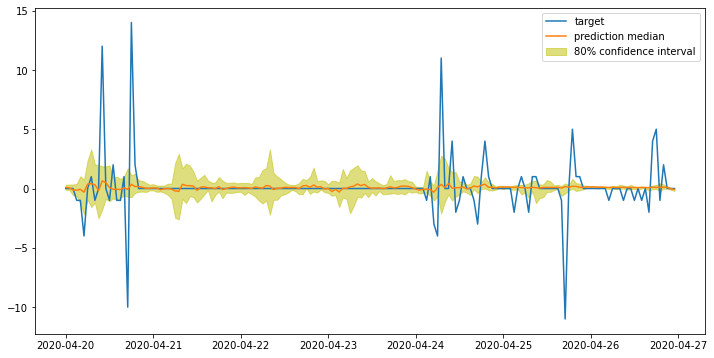

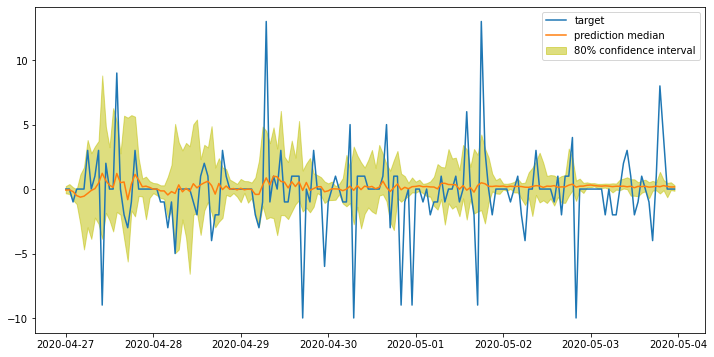

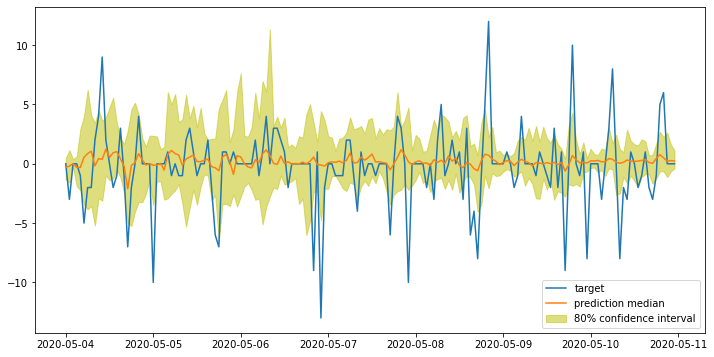

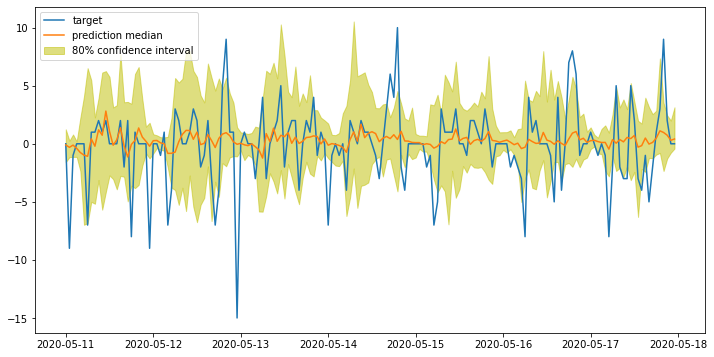

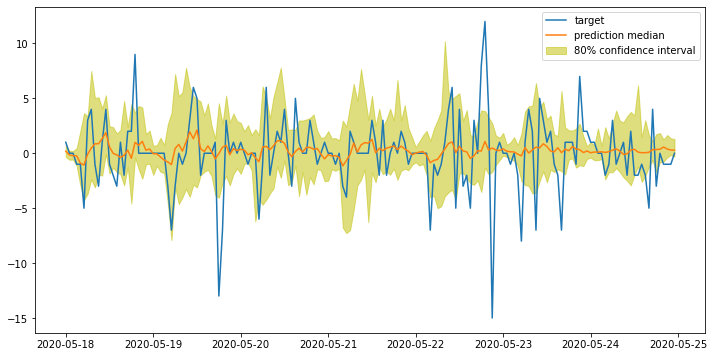

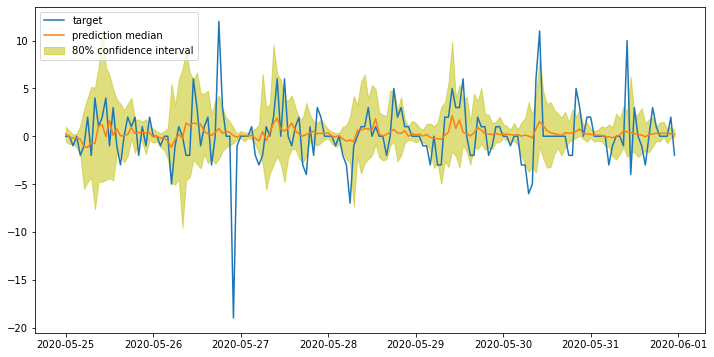

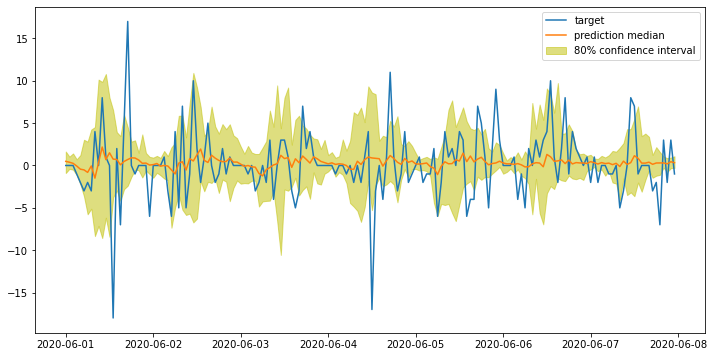

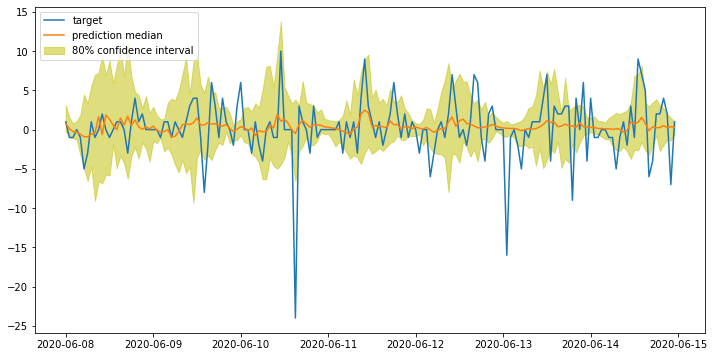

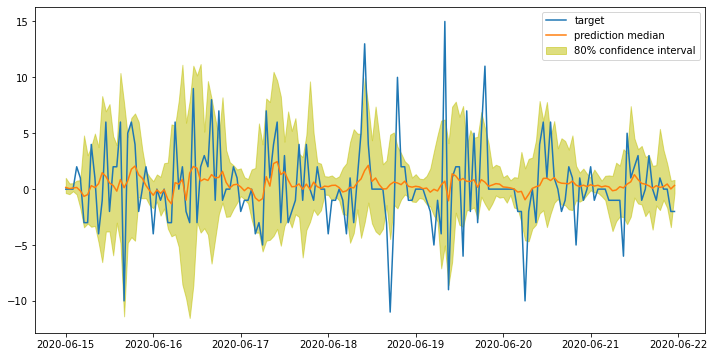

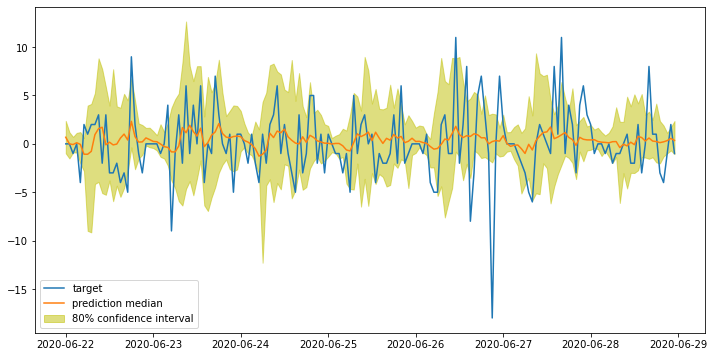

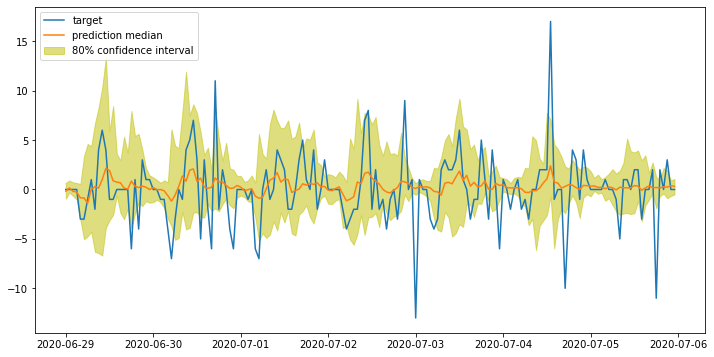

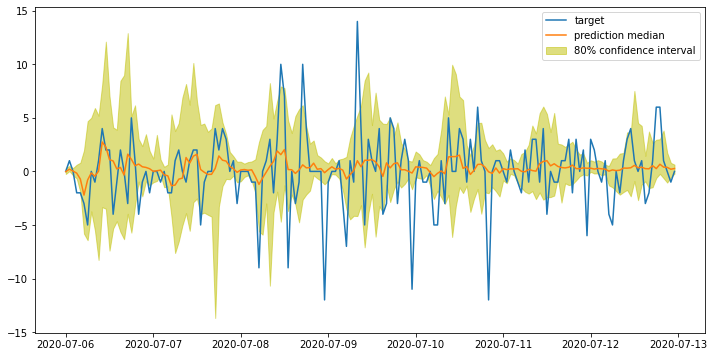

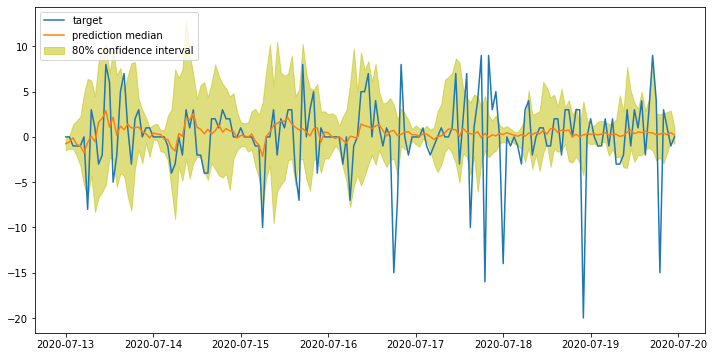

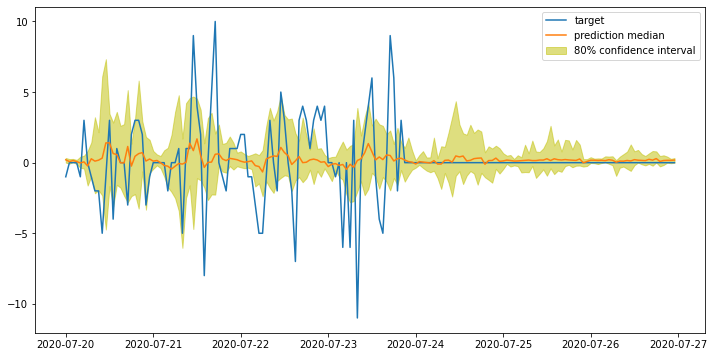

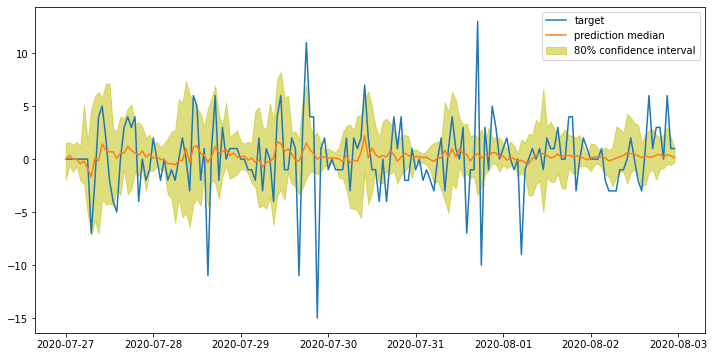

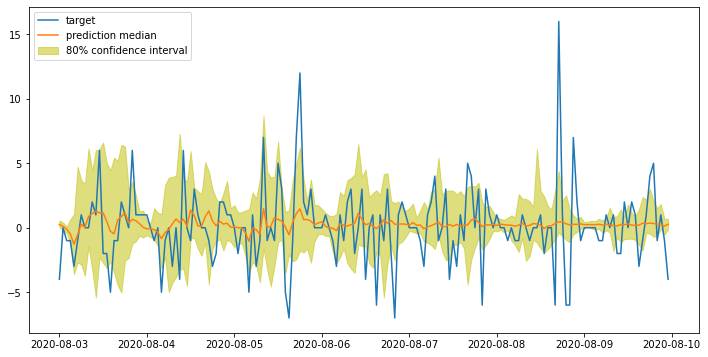

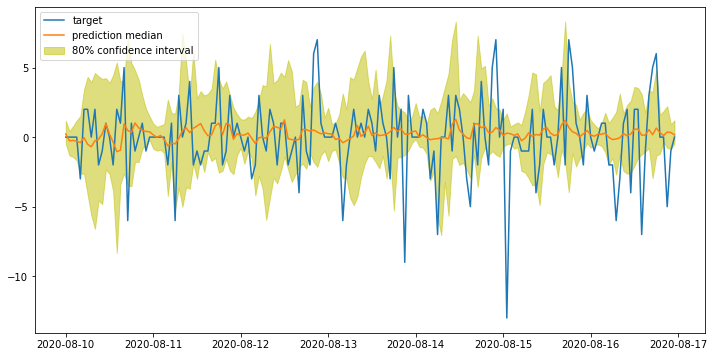

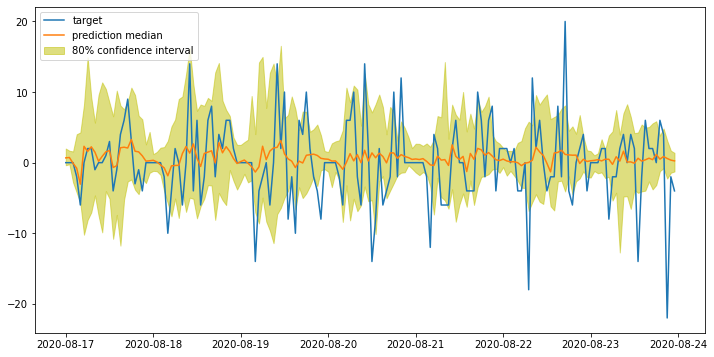

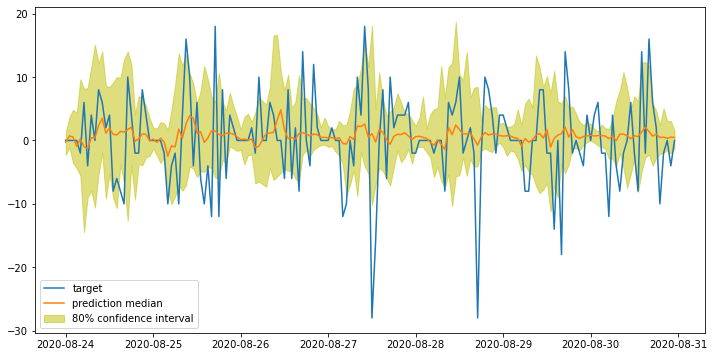

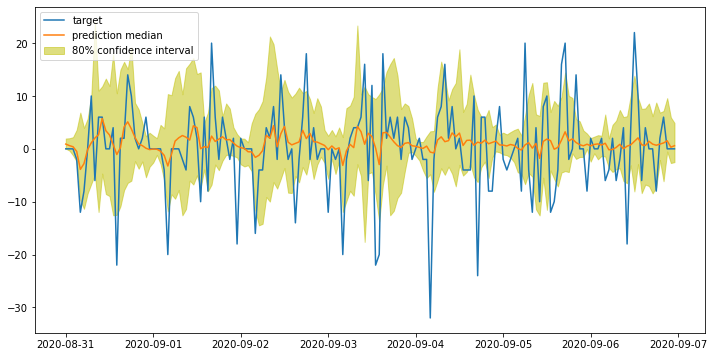

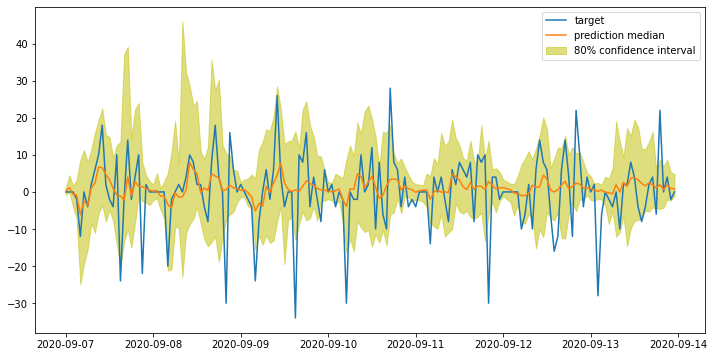

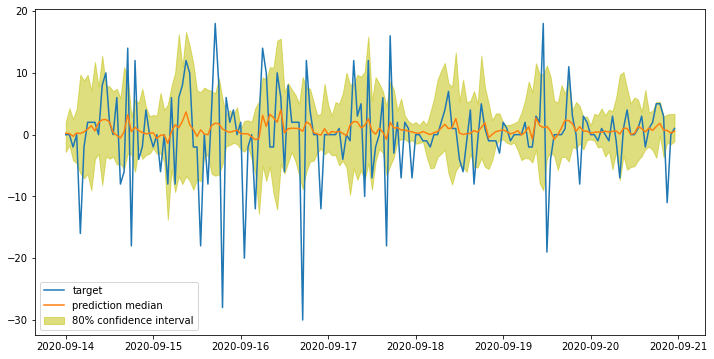

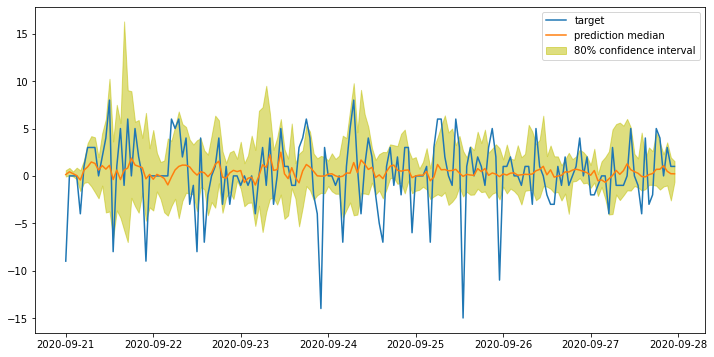

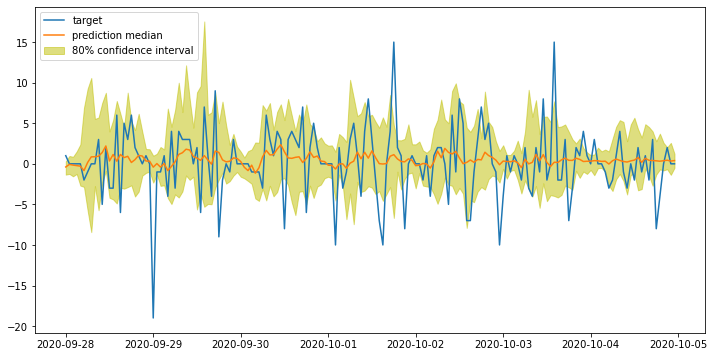

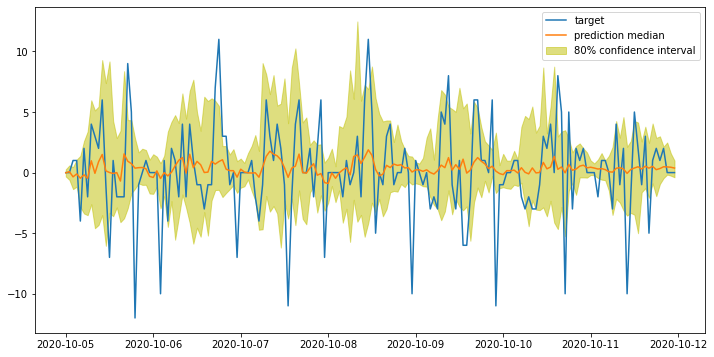

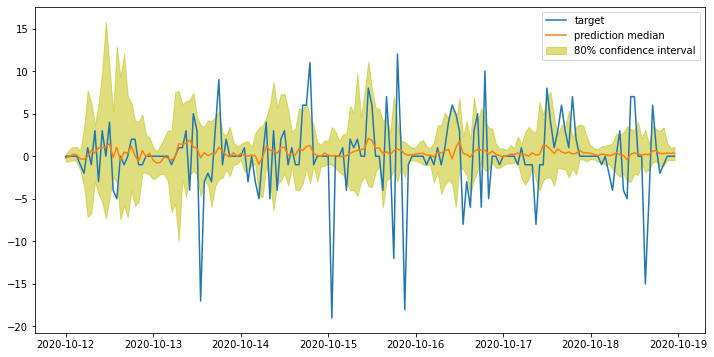

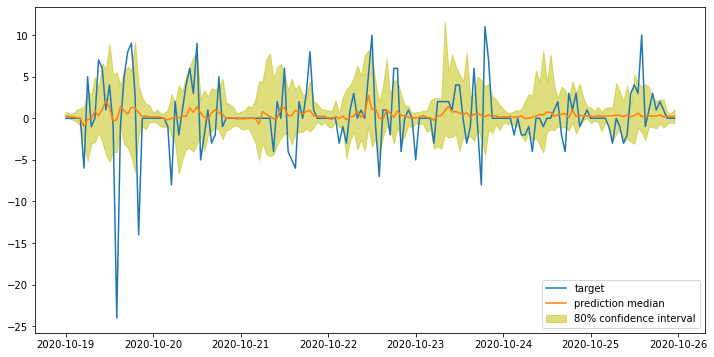

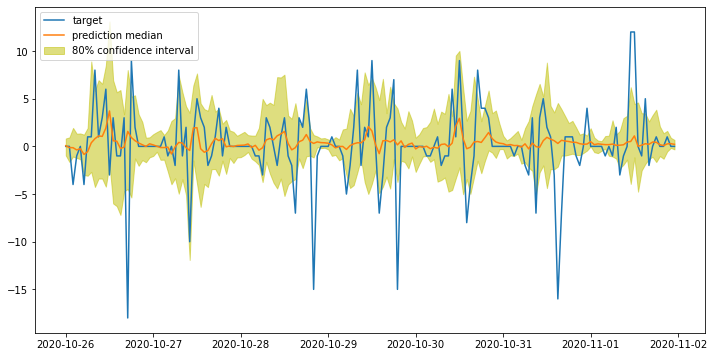

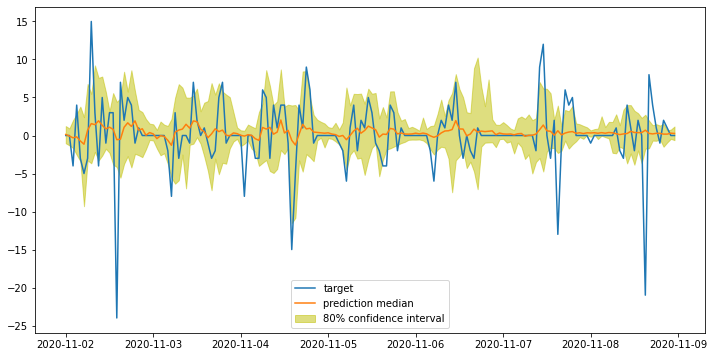

In [43]:
# display predictions
target_ts = []
start_dates = []
for instance in json_input_ts['instances']:
    target_ts.append(instance['target'])
    start_dates.append(instance['start'])
    

display_quantiles(prediction_list, start_dates, target_ts)

## Predicting the Future

Now let's see if we can predict the bicing usage given **no target**, only a known start date! For comparison we can use the part of the test set that is not shared with the training set.

### Remove training data from the test set

From the test_key json file are isolated the latest data covering a full prediction horizon: last fo the four weeks on each month. The 'start' date in this case represents the start of the month like in the other datasets.


Extract last week for each month for testing purpose

In [55]:
with open(test_key) as json_file:
    
    instances = []
    for line in json_file:
        # get JSON objects for input time series
        instances.append(json.loads(line))

new_target_ts = []
for instance in instances:
    new_target_ts.append({'start':instance['start'],'target':instance['target'][-prediction_length:]})
    
print(new_target_ts[0])

{'start': '2019-04-01 00:00:00', 'target': [2.0, 0.0, -1.0, 0.0, -1.0, 0.0, 1.0, 0.0, -1.0, 1.0, -4.0, 5.0, 2.0, 4.0, -5.0, 1.0, 1.0, -2.0, -3.0, 1.0, 6.0, 2.0, 1.0, 0.0, 0.0, -7.0, 0.0, -1.0, -3.0, 0.0, 1.0, -2.0, -1.0, 4.0, 19.0, -9.0, 2.0, 1.0, -3.0, 3.0, -1.0, 1.0, 4.0, 3.0, 0.0, -7.0, 3.0, 1.0, 2.0, -1.0, -1.0, 0.0, -8.0, 7.0, 16.0, -1.0, 2.0, -1.0, 1.0, -1.0, -2.0, 3.0, -2.0, -8.0, 6.0, 4.0, 0.0, 0.0, 0.0, -7.0, -11.0, 0.0, -1.0, 0.0, 0.0, -1.0, -1.0, 6.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, -6.0, 6.0, 0.0, 0.0, 0.0, -1.0, 1.0, -7.0, 6.0, 9.0, 3.0, -1.0, 2.0, -12.0, 12.0, 0.0, -1.0, -17.0, 7.0, 4.0, 7.0, -2.0, 2.0, 0.0, 0.0, 0.0, 0.0, -2.0, 2.0, 0.0, -1.0, 1.0, -8.0, 2.0, 1.0, 2.0, -3.0, 3.0, -3.0, -3.0, 8.0, -1.0, -3.0, 3.0, -2.0, 1.0, 1.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, -14.0, -2.0, 0.0, 4.0, -3.0, -3.0, 3.0, 6.0, 0.0, 1.0, 3.0, -8.0, 6.0, 8.0, 0.0, -1.0, -6.0, 0.0, 0.0]}


### Format a request for a "future" prediction

Create a formatted input to send to the deployed `predictor` passing in the usual parameters for "configuration". The "instances" will, in this case, just be one instance, defined by the following:

* **start**: The start time will be time stamp that you specify. It is just a starting reference.
* **target**: The target will be an empty list because this year has no, complete associated time series; we specifically withheld that information from our model, for testing purposes.
```
{"start": start_time, "target": []} # empty target```

In [73]:
# formatting start_date
import datetime
start_time = new_target_ts[0]['start']
start_time = datetime.datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S') + datetime.timedelta(days=7*3)
start_time = start_time.strftime("%Y-%m-%d %H:%M:%S")

# formatting request_data
# this instance has an empty target!
request_data = {"instances": [{"start": start_time, "target": []}],
                "configuration": {"num_samples": 50,
                                  "output_types": ["quantiles"],
                                  "quantiles": ['0.1', '0.5', '0.9']}
                }

json_input = request_data

print('Requesting prediction for '+start_time)

Requesting prediction for 2019-04-22 00:00:00


In [74]:
# get prediction response
json_prediction = predictor.predict(json_input)

prediction_forecast = decode_prediction(json_prediction)

Finally, I'll compare the predictions to a known target sequence. This target will come from a test time data extracted above from the last week of the month.

In [75]:
# create test time serie (to be improved to process all the months of data)
start_date = start_time
ts_forecast = []

# get data from the first month of data
data_forecast = new_target_ts[0]['target']

index = pd.date_range(start=start_date, periods=len(data_forecast), freq='H')
ts_forecast.append(pd.Series(data=data_forecast, index=index))

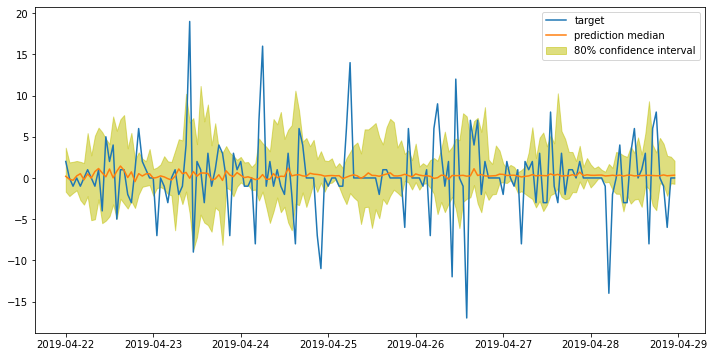

In [76]:
# range of actual data to compare
start_idx=0
end_idx=start_idx+prediction_length

# get target data
target_forecast_ts = [ts_forecast[0][start_idx:end_idx]]

# display predictions
display_quantiles(prediction_forecast, [start_date], target_forecast_ts)

## Delete the Endpoint

Make sure to delete the endpoint after the job is done.

In [77]:
## TODO: delete the endpoint
predictor.delete_endpoint()

## Conclusion

First next improvement will target:
* process data from the beginning using dates and provide series not starting from the first day of the month but from the first Monday of the month.
* clean out data from the period of time when stations are out of service.
* improve the analysis of the model training and study different hyperparameters configurations

Further improvement will include:
* Moving from single to multivariate time series forecasting model to catch interdependency of bicing usage between stations. 
* Include correlation to weather data. The usage of bicing can be highly influenced by a rainy day.

THE END